In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 50
multi_periods = [25, 50, 100]
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
#contract = contract.loc['20190401':]
contract = contract.loc['20180202': '20180430']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

10866.219807898575

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2018-02-02 02:05:00,6954.00,6963.50,6941.00,6943.00,5677,10849
1,2018-02-02 04:07:00,6943.25,6944.00,6912.50,6937.75,5955,10931
2,2018-02-02 08:51:00,6937.50,6944.00,6920.00,6928.50,6744,11023
3,2018-02-02 10:16:00,6928.75,6929.25,6888.00,6891.25,5925,10905
4,2018-02-02 11:16:00,6891.00,6894.00,6857.75,6868.25,5977,10697
...,...,...,...,...,...,...,...
2604,2018-04-30 21:36:00,6626.25,6636.00,6613.50,6630.75,6126,11175
2605,2018-04-30 21:50:00,6630.75,6641.25,6622.50,6623.75,5455,10648
2606,2018-04-30 21:58:00,6623.75,6623.75,6615.00,6615.75,3701,7953


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
data['change'] = data['close'] - data['close'].shift(1)
data['up'] = (data['change'] > 0) * data['change']
data['down'] = ((data['change'] < 0) * data['change']).abs()
data

,date,open,close,change,up,down
label,,,,,,
0,2018-02-02 02:05:00,6954.00,6943.00,NaN,NaN,NaN
1,2018-02-02 04:07:00,6943.25,6937.75,-5.25,-0.00,5.25
2,2018-02-02 08:51:00,6937.50,6928.50,-9.25,-0.00,9.25
3,2018-02-02 10:16:00,6928.75,6891.25,-37.25,-0.00,37.25
4,2018-02-02 11:16:00,6891.00,6868.25,-23.00,-0.00,23.00
...,...,...,...,...,...,...
2604,2018-04-30 21:36:00,6626.25,6630.75,4.25,4.25,0.00
2605,2018-04-30 21:50:00,6630.75,6623.75,-7.00,-0.00,7.00
2606,2018-04-30 21:58:00,6623.75,6615.75,-8.00,-0.00,8.00


In [20]:
data['rs'] = data['up'].ewm(span=periods, min_periods=periods*.9).mean() / data['down'].ewm(span=periods, min_periods=periods*.9).mean()
data['rsi'] = (100 - (100 / (1 + data['rs'])))
data['rsi_mod'] = data['rsi'] - 50
data['rsi_mod'] *= -1.3
data['rsi_mod'] = data['rsi_mod'].clip(lower=-20, upper=20)
data

,date,open,close,change,up,down,rs,rsi,rsi_mod
label,,,,,,,,,
0,2018-02-02 02:05:00,6954.00,6943.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-02 04:07:00,6943.25,6937.75,-5.25,-0.00,5.25,NaN,NaN,NaN
2,2018-02-02 08:51:00,6937.50,6928.50,-9.25,-0.00,9.25,NaN,NaN,NaN
3,2018-02-02 10:16:00,6928.75,6891.25,-37.25,-0.00,37.25,NaN,NaN,NaN
4,2018-02-02 11:16:00,6891.00,6868.25,-23.00,-0.00,23.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2604,2018-04-30 21:36:00,6626.25,6630.75,4.25,4.25,0.00,0.839286,45.631087,5.679587
2605,2018-04-30 21:50:00,6630.75,6623.75,-7.00,-0.00,7.00,0.793843,44.253762,7.470109
2606,2018-04-30 21:58:00,6623.75,6615.75,-8.00,-0.00,8.00,0.745809,42.719950,9.464066


In [21]:
10/data['rsi_mod'].abs().mean()

1.0546912479921036

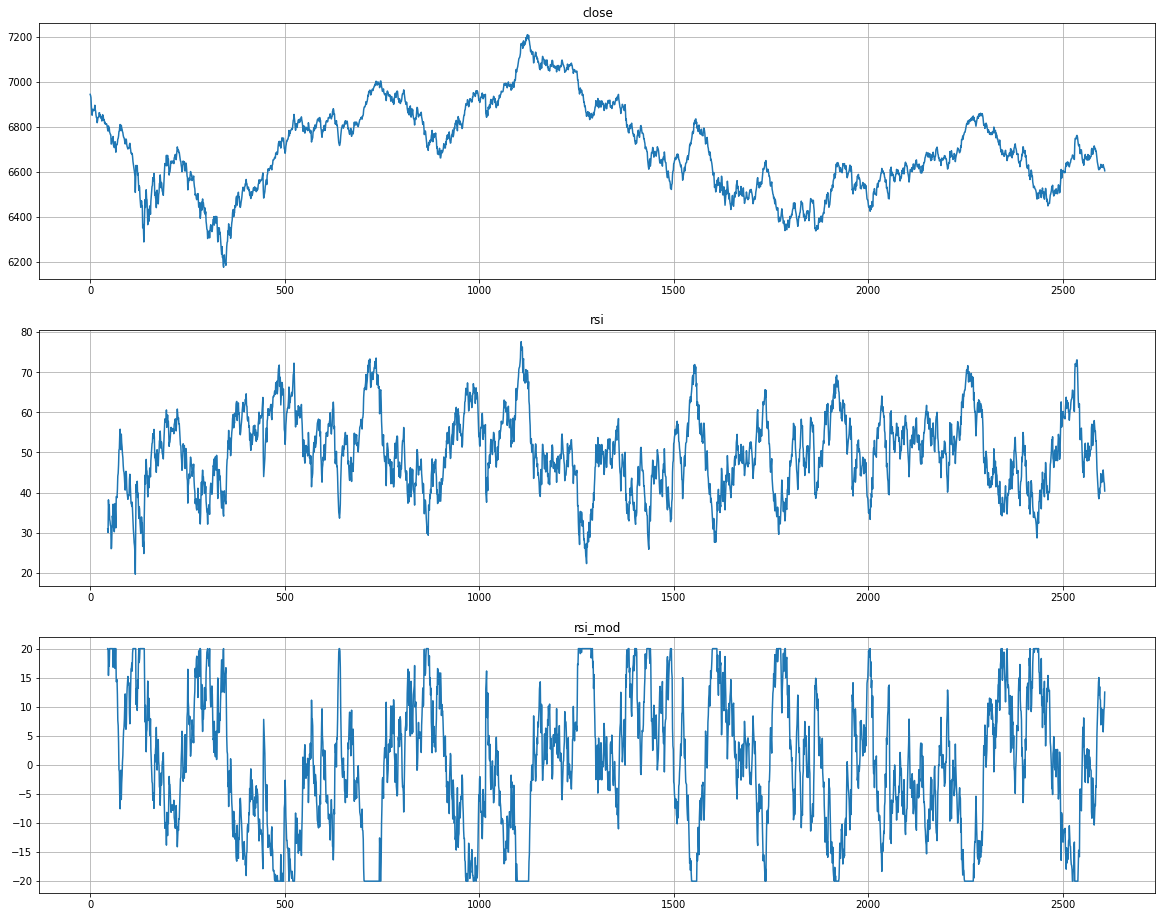

In [22]:
plot(data[['close', 'rsi', 'rsi_mod']])

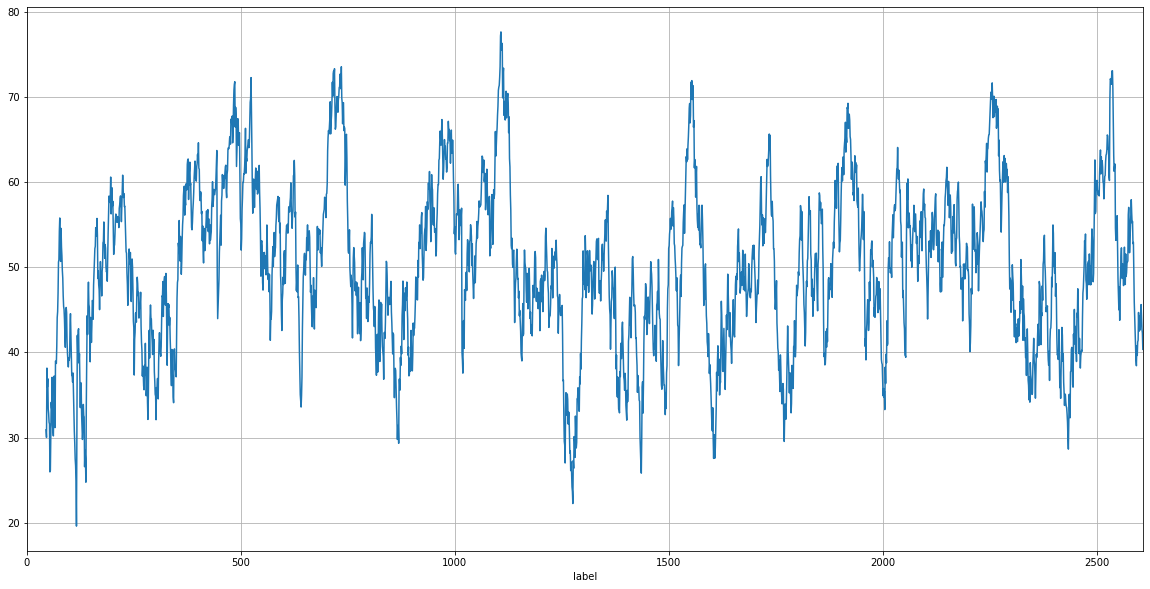

In [24]:
data['rsi'].plot(figsize=(20,10), grid=True);

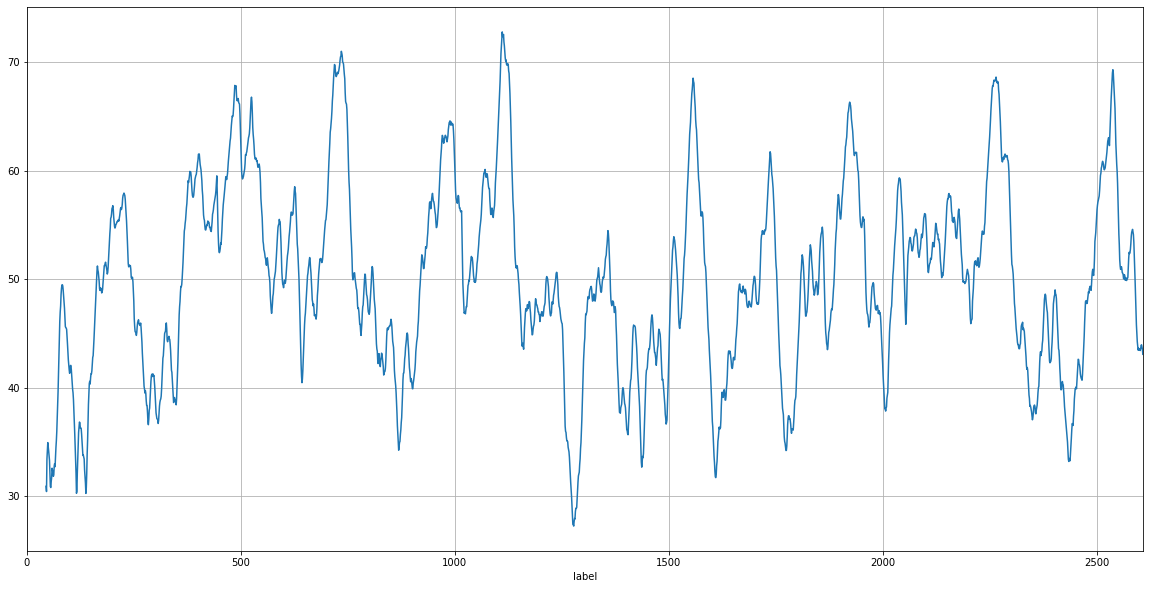

In [35]:
data['rsi'].ewm(span=periods/4).mean().plot(figsize=(20, 10), grid=True);

In [33]:
signals = ((data['rsi'] > 60) * -1) + ((data['rsi'] < 40) * 1)
signals

label
0       0
1       0
2       0
3       0
4       0
       ..
2604    0
2605    0
2606    0
2607    0
2608    0
Name: rsi, Length: 2609, dtype: int64

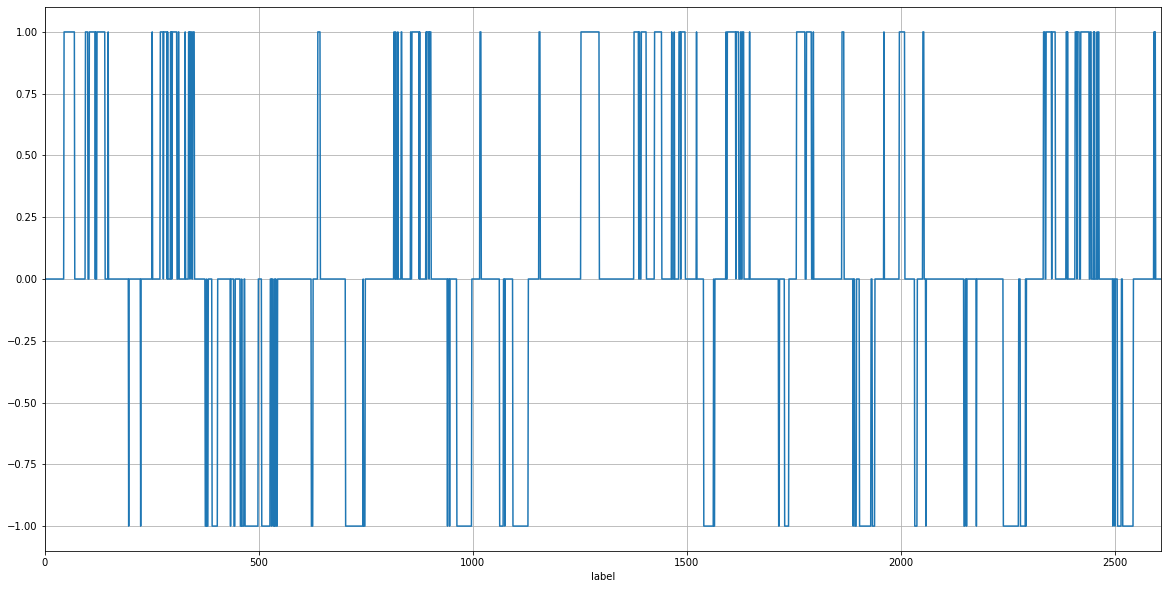

In [34]:
signals.plot(figsize=(20, 10), grid=True);